## Import Necessary Packages

In [2]:
import pickle
import warnings
import numpy as np
import pandas as pd
import proplot as pplt
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## Load Results

In [7]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/'

with open(f'{FILEDIR}/results/baseline_results.pkl','rb') as file:
    baseresults = pickle.load(file)
with open(f'{FILEDIR}/results/linear_results.pkl','rb') as file:
    linresults = pickle.load(file)
with open(f'{FILEDIR}/results/nonlinear_results.pkl','rb') as file:
    nonlinresults = pickle.load(file)

xtrue = pd.read_parquet(f'{FILEDIR}/processed/Xtest.parquet')['bl']
ytrue = pd.read_parquet(f'{FILEDIR}/processed/ytest.parquet')['pr']

## Functions

In [8]:
def clean_data(*arrays):
    arrays  = [np.array(array) for array in arrays]
    lengths = [len(array) for array in arrays]
    if len(set(lengths))>1:
        raise ValueError(f'All arrays must have same length. Got lengths: {lengths}')
    validmask = np.ones(len(arrays[0]),dtype=bool)
    for array in arrays:
        validmask &= np.isfinite(array)
    cleanedarrays = [array[validmask] for array in arrays]
    if len(cleanedarrays)==1:
        return cleanedarrays[0]
    else:
        return tuple(cleanedarrays)

## Baseline Relationships

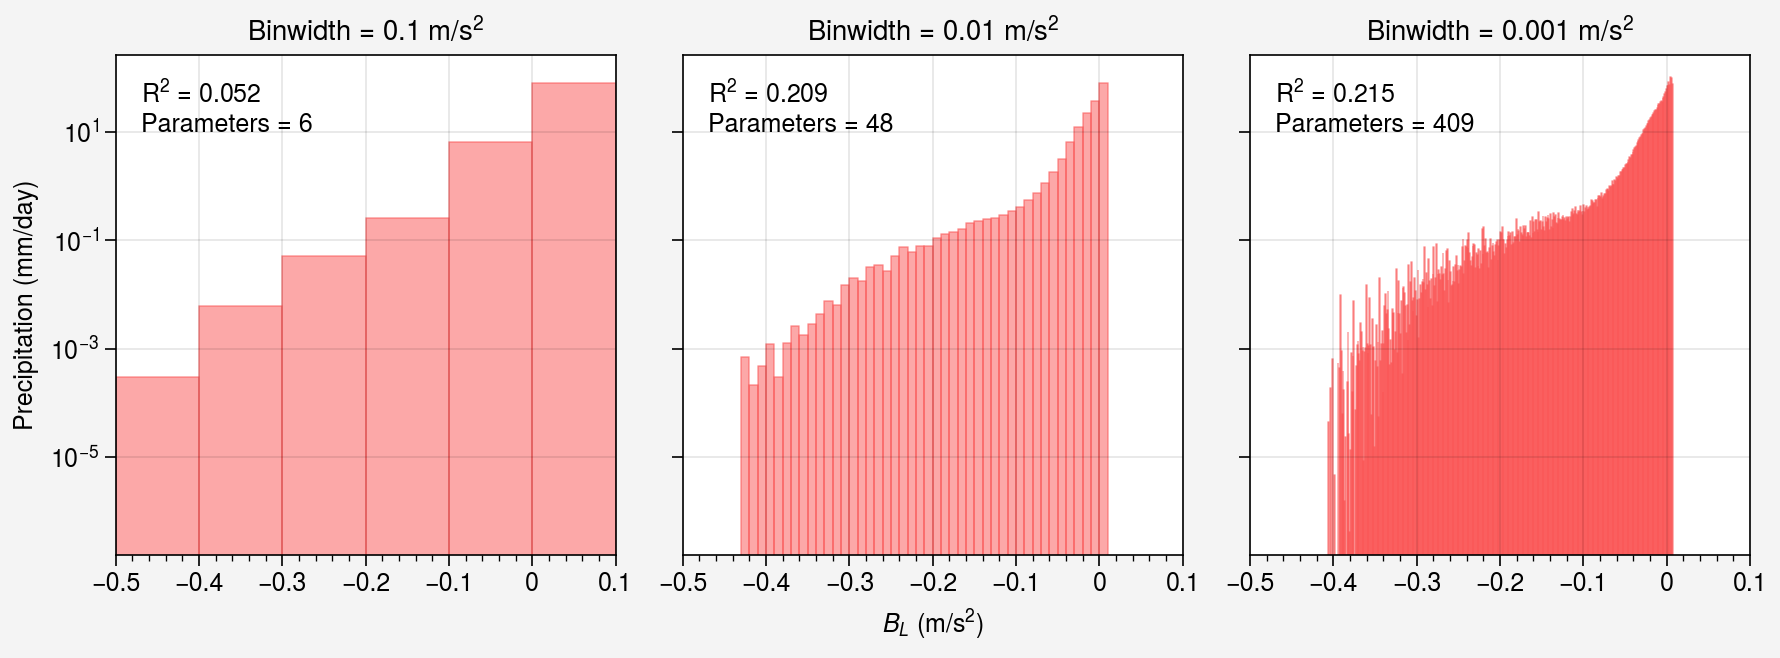

In [9]:
fig,axs = pplt.subplots(nrows=1,ncols=3,share=True)
axs.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.5,0.1),xticks=0.1,ylabel='Precipitation (mm/day)',yscale='log',yformatter='log')
for i,(modelname,results) in enumerate(baseresults.items()):
    title    = results['description']
    bins     = results['bincenters']
    means    = results['binmeans']
    binwidth = results['binwidth']
    ypred    = results['ypred']
    nparams  = results['nparams']
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    r2 = r2_score(ytrueclean,ypredclean)
    axs[i].format(title=f'{title} m/s$^2$')
    for bincenter,meanvalue in zip(bins,means):
        if not np.isnan(meanvalue):
            leftedge  = bincenter-binwidth/2
            rightedge = bincenter+binwidth/2
            axs[i].fill_between([leftedge,rightedge],[0,0],[meanvalue,meanvalue],color='red6',edgecolor='red6',alpha=0.5)
    axs[i].text(0.05,0.95,f'R$^2$ = {r2:.3f}\nParameters = {nparams}',transform=axs[i].transAxes,va='top')
pplt.show()

## Model Training and Validation Losses

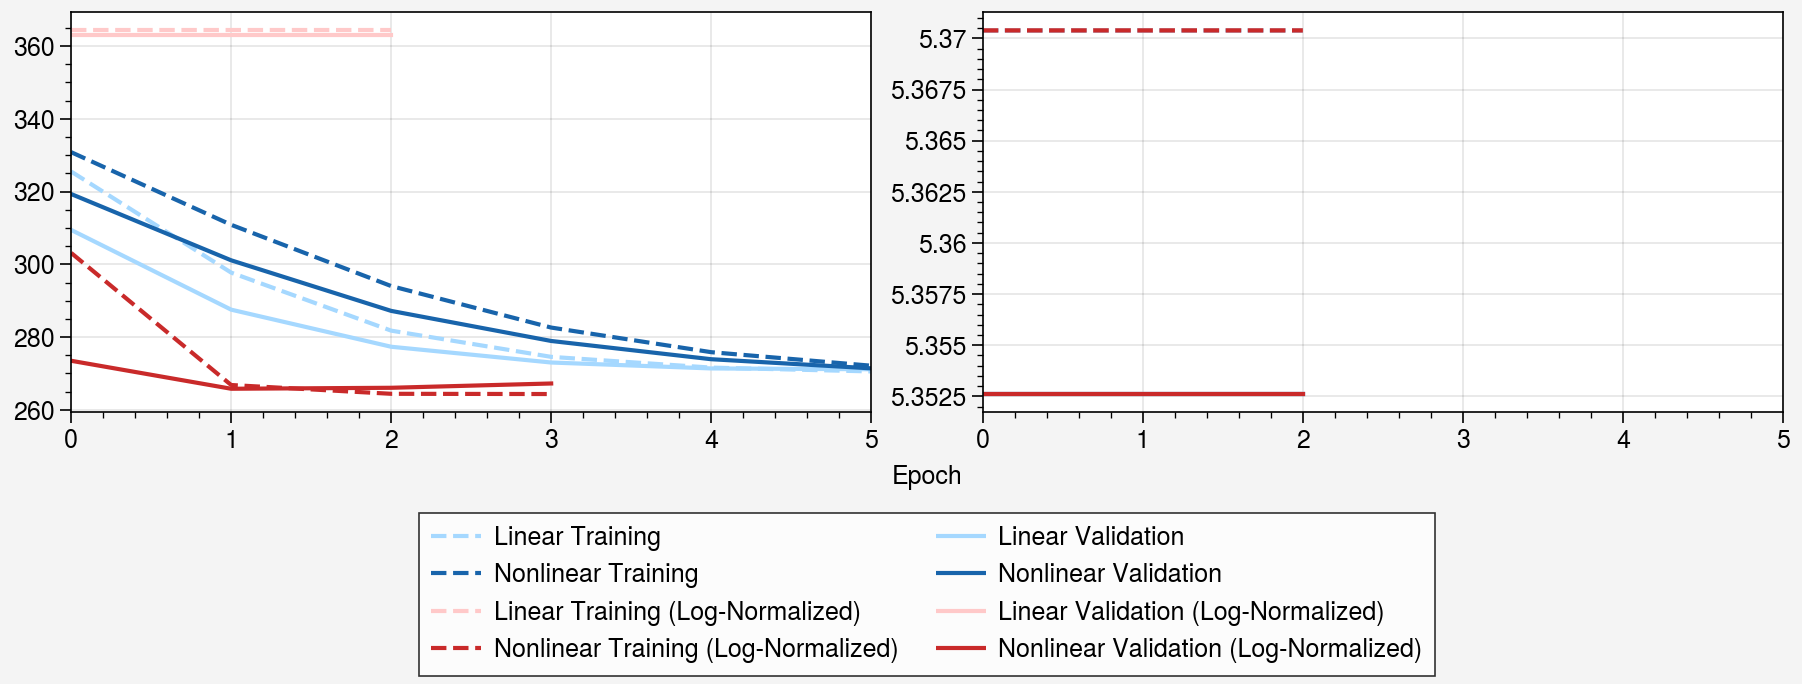

In [11]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epoch',xlim=(0,5),xticks=1)
# axs[0].format(title='MSE Loss Comparison',ylabel='MSE (mm/day)$^2$',ylim=(260,370),yticks=20,yminorticks='none')
# axs[1].format(title='MAE Loss Comparison',ylabel='MAE (mm/day)',ylim=(4.7,5.4))
colors = ['blue2','blue9','red2','red9']
for i,(ax,loss) in enumerate(zip(axs,['mse','mae'])):
    ax.plot(linresults[f'linear_{loss}']['trainlosses'],color=colors[0],linestyle='--',label='Linear Training' if i==0 else None)
    ax.plot(linresults[f'linear_{loss}']['validlosses'],color=colors[0],linestyle='-',label='Linear Validation' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}']['trainlosses'],color=colors[1],linestyle='--',label='Nonlinear Training' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}']['validlosses'],color=colors[1],linestyle='-',label='Nonlinear Validation' if i==0 else None)
    ax.plot(linresults[f'linear_{loss}_log']['trainlosses'],color=colors[2],linestyle='--',label='Linear Training (Log-Normalized)' if i==0 else None)
    ax.plot(linresults[f'linear_{loss}_log']['validlosses'],color=colors[2],linestyle='-',label='Linear Validation (Log-Normalized)' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}_log']['trainlosses'],color=colors[3],linestyle='--',label='Nonlinear Training (Log-Normalized)' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}_log']['validlosses'],color=colors[3],linestyle='-',label='Nonlinear Validation (Log-Normalized)' if i==0 else None)
fig.legend(loc='b',ncols=2)
pplt.show()

## Cleaning All Precipitation Predictions

In [12]:
allmodels = []

for modelname,results in baseresults.items():
    ypred = results['ypred']
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    allmodels.append({
        'name':modelname,
        'description':results['description'],
        'ytrue':ytrueclean,
        'ypred':ypredclean,
        'nparams':results.get('nparams',None),
        'type':'baseline'})

for modelname,results in linresults.items():
    if results.get('logtransform',False):
        ypred = np.exp(results['ypred'])-1
    else:
        ypred = results['ypred']
    ypred = np.squeeze(ypred)
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    allmodels.append({
        'name':modelname,
        'description':results['description'],
        'ytrue':ytrueclean,
        'ypred':ypredclean,
        'nparams':results.get('nparams',None),
        'type':'linear'})

for modelname,results in nonlinresults.items():
    if results.get('logtransform',False):
        ypred = np.exp(results['ypred'])-1
    else:
        ypred = results['ypred']
    ypred = np.squeeze(ypred) 
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    allmodels.append({
        'name':modelname,
        'description':results['description'],
        'ytrue':ytrueclean,
        'ypred':ypredclean,
        'nparams':results.get('nparams',None),
        'type':'nonlinear'})

## Calculate Global Min/Max

In [13]:
allytrue = []
allypred = []
for model in allmodels:
    allytrue.extend(model['ytrue'])
    allypred.extend(model['ypred'])
globalmin = min(min(allytrue),min(allypred))
globalmax = max(max(allytrue),max(allypred))
print(f'Global data range: {globalmin:.6f} to {globalmax:.3f} mm/day')

Global data range: 0.000000 to 876.113 mm/day


## Actual vs. Predicted Precipitation

In [ ]:
# ticks   = [1e-8,1e-6,1e-4,1e-2,1e0,1e2,1e4]
ncols   = 3
nrows   = (len(allmodels[:3])+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,share=True)
for i,model in enumerate(allmodels[:3]):
    row = i//ncols
    col = i%ncols
    r2  = r2_score(model['ytrue'],model['ypred'])
    nonzeromask = (model['ytrue']>0)&(model['ypred']>0)
    ytruemasked = model['ytrue'][nonzeromask]
    ypredmasked = model['ypred'][nonzeromask]
    mesh = axs[row,col].hexbin(ytruemasked,ypredmasked,gridsize=(20,20),cmap='ColdHot',mincnt=1,xscale='log',yscale='log',norm='log')
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=2)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2:.3f}',transform=axs[row,col].transAxes,va='top')
    axs[row,col].format(title=f'{model["description"]} m/s$^2$')
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xlim=[globalmin,globalmax],xformatter='log',
           # xticks=ticks,xminorticks='none',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',ylim=[globalmin,globalmax],yformatter='log',
           # yticks=ticks,yminorticks='none'
          )
fig.colorbar(mesh,loc='r',label='Counts',ticks=[1,10,100,1000,10000])
pplt.show()

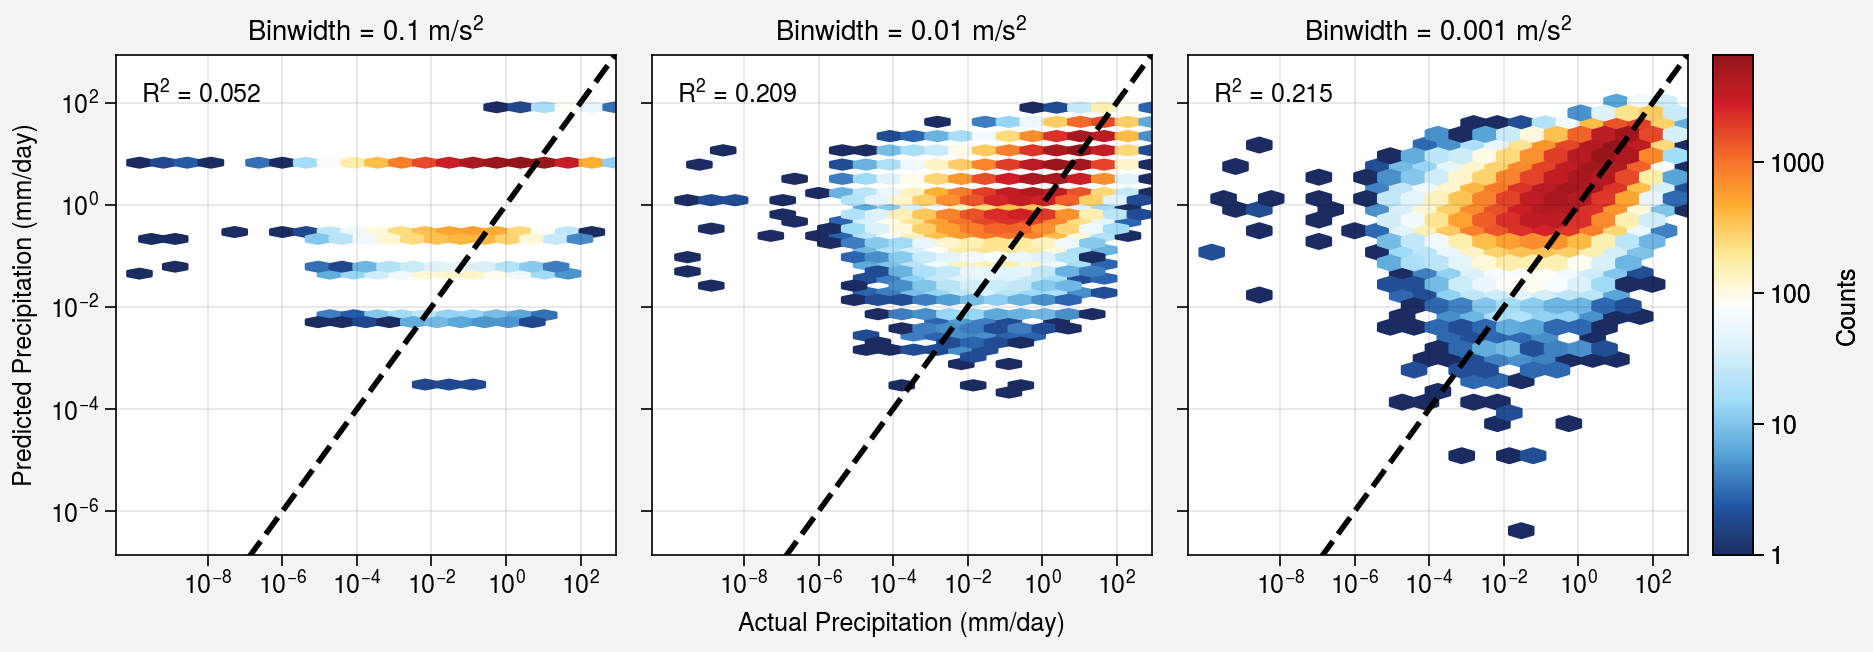

In [14]:
ticks   = [1e-8,1e-6,1e-4,1e-2,1e0,1e2,1e4]
ncols   = 3
nrows   = (len(allmodels[:3])+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,share=True)
for i,model in enumerate(allmodels[:3]):
    row = i//ncols
    col = i%ncols
    r2  = r2_score(model['ytrue'],model['ypred'])
    nonzeromask = (model['ytrue']>0)&(model['ypred']>0)
    ytruemasked = model['ytrue'][nonzeromask]
    ypredmasked = model['ypred'][nonzeromask]
    mesh = axs[row,col].hexbin(ytruemasked,ypredmasked,gridsize=(20,20),cmap='ColdHot',mincnt=1,xscale='log',yscale='log',norm='log')
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=2)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2:.3f}',transform=axs[row,col].transAxes,va='top')
    axs[row,col].format(title=f'{model["description"]} m/s$^2$')
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xlim=[globalmin,globalmax],xformatter='log',xticks=ticks,xminorticks='none',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',ylim=[globalmin,globalmax],yformatter='log',yticks=ticks,yminorticks='none')
fig.colorbar(mesh,loc='r',label='Counts',ticks=[1,10,100,1000,10000])
pplt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

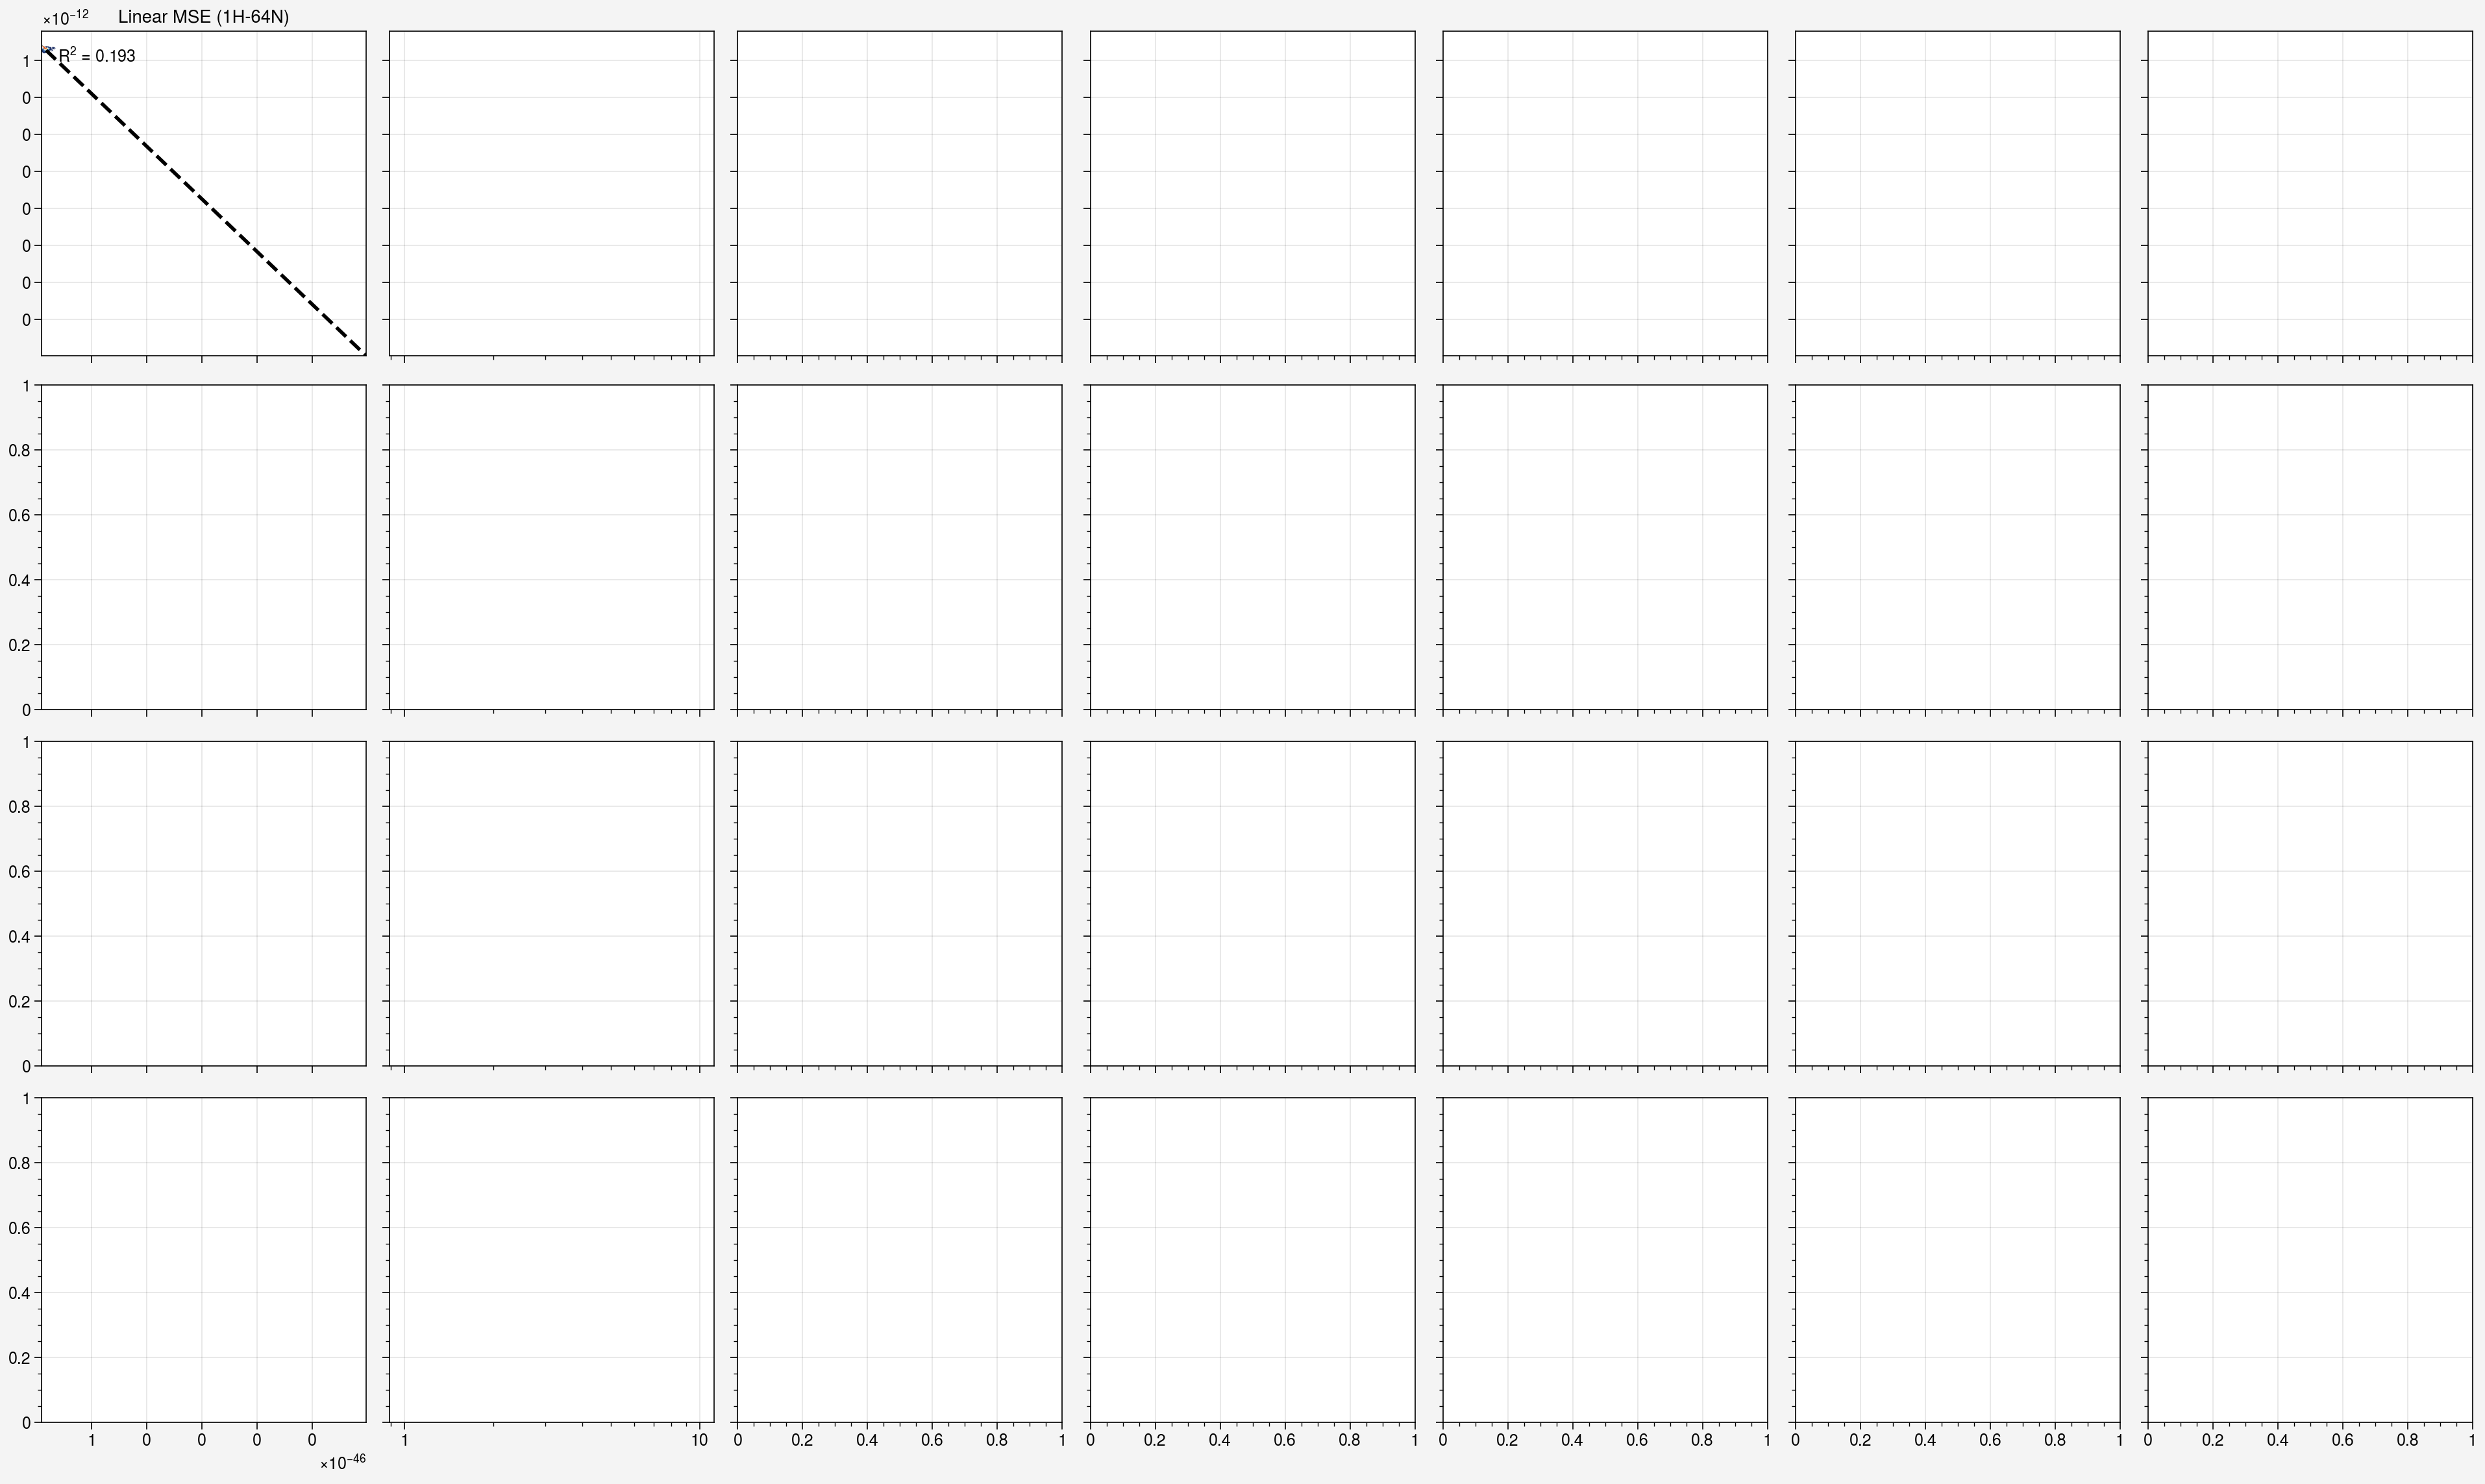

In [15]:
ticks   = [1e-8,1e-6,1e-4,1e-2,1e0,1e2,1e4]
ncols   = 7
nrows   = (len(allmodels[3:])+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,share=True)
for i,model in enumerate(allmodels[3:]):
    row = i//ncols
    col = i%ncols
    r2  = r2_score(model['ytrue'],model['ypred'])
    nonzeromask = (model['ytrue']>0)&(model['ypred']>0)
    ytruemasked = model['ytrue'][nonzeromask]
    ypredmasked = model['ypred'][nonzeromask]
    mesh = axs[row,col].hexbin(ytruemasked,ypredmasked,gridsize=(20,20),cmap='ColdHot',mincnt=1,xscale='log',yscale='log',norm='log')
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=2)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2:.3f}',transform=axs[row,col].transAxes,va='top')
    axs[row,col].format(title=f'{model["description"]}')
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xlim=[globalmin,globalmax],xformatter='log',xticks=ticks,xminorticks='none',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',ylim=[globalmin,globalmax],yformatter='log',yticks=ticks,yminorticks='none')
fig.colorbar(mesh,loc='r',label='Counts',ticks=[1,10,100,1000,10000])
pplt.show()

## Actual vs. Predicted Amount Distributons

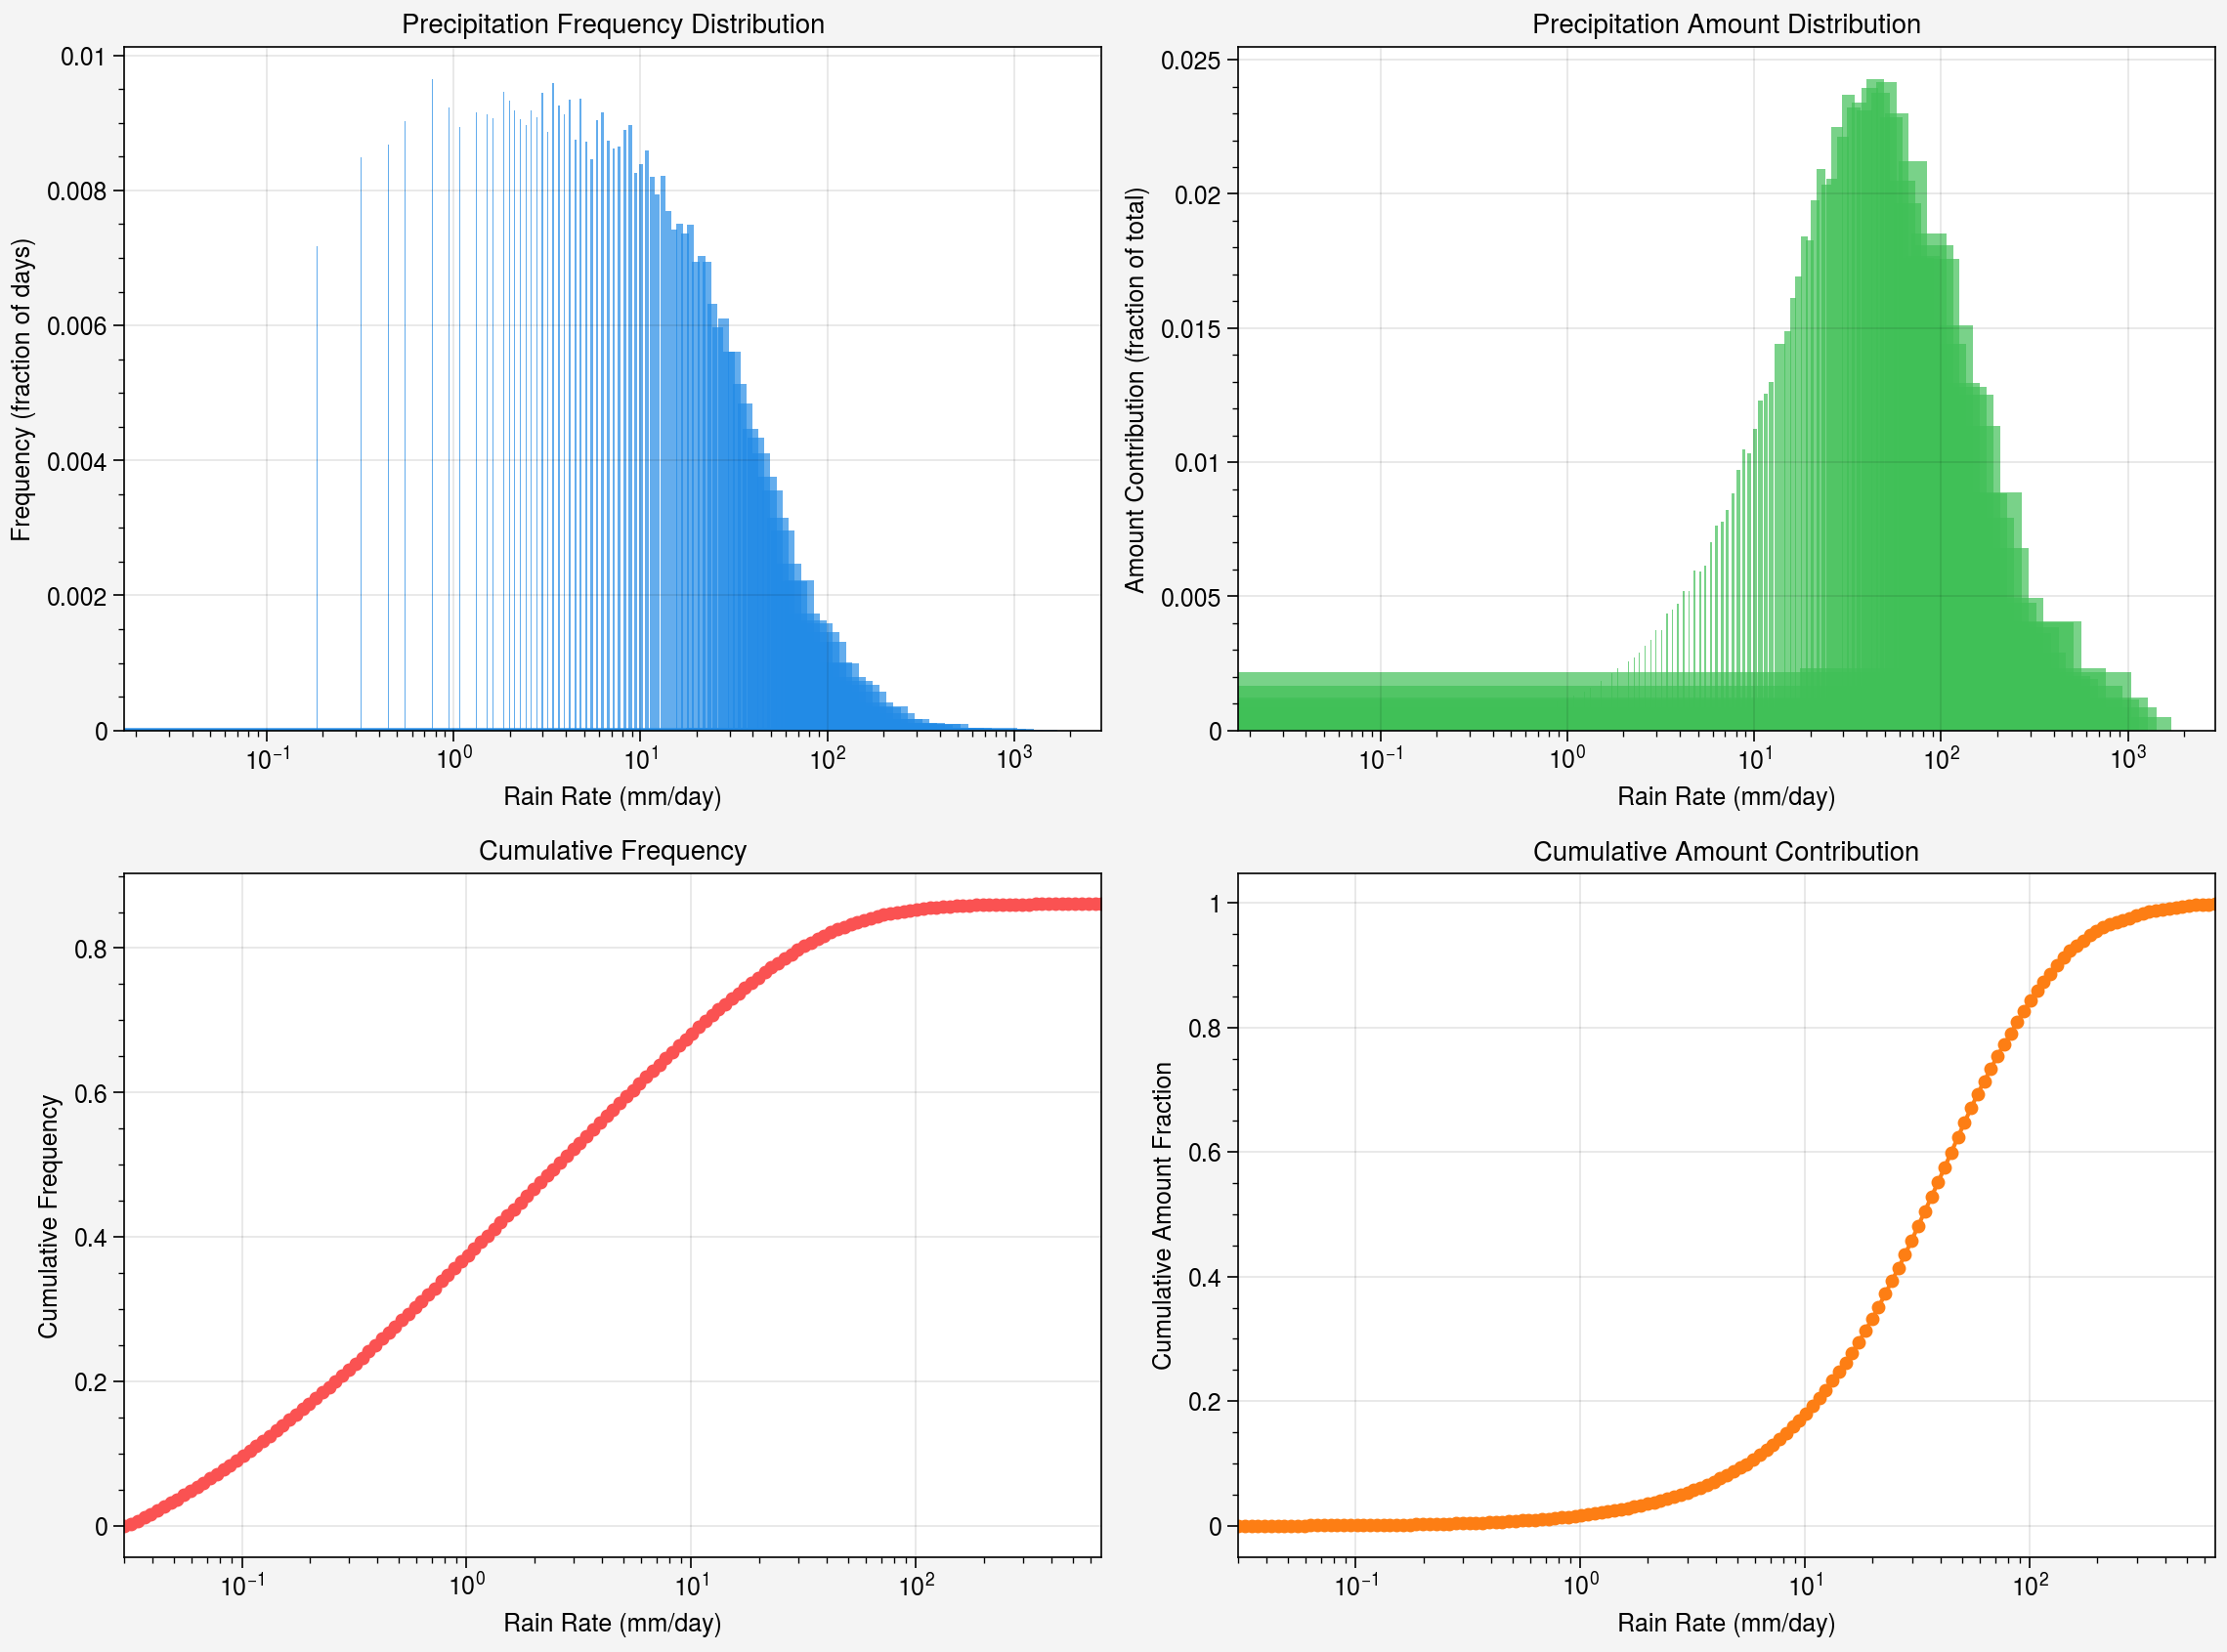

=== PRECIPITATION AMOUNT DISTRIBUTION SUMMARY ===
Dry threshold: 0.0321 mm/day
Total days: 176,285
Dry days: 24,487 (13.9%)
Wet days: 151,798 (86.1%)
Total rainfall: 1332570.5 mm
Mean daily rainfall (all days): 7.559 mm/day
Mean daily rainfall (wet days only): 8.779 mm/day

Bin structure:
Number of bins: 149
Smallest bin center: 0.0300 mm/day
Largest bin center: 669.8 mm/day

Most frequent rain rate:
  Bin center: 0.772 mm/day
  Frequency: 0.96% of days

Largest amount contribution:
  Bin center: 44.727 mm/day
  Amount contribution: 2.4% of total rainfall


In [113]:
def create_log_rain_bins(binspacing=0.05,minleftedge=0.025,maxcenter=1500):
    firstcenter = minleftedge/(1-binspacing/2)
    center      = firstcenter
    bincenters  = []
    binwidths   = []
    while center<=maxcenter:
        width = center*(binspacing)
        bincenters.append(center)
        binwidths.append(width)
        center  = center*(1+binspacing)
    bincenters  = np.array(bincenters)
    binwidths   = np.array(binwidths)
    binedges    = np.zeros(len(bincenters)+1)
    binedges[0] = bincenters[0]-binwidths[0]/2
    for i in range(len(bincenters)):
        binedges[i+1] = bincenters[i]+binwidths[i]/2
    return bincenters,binwidths,binedges

def calculate_amount_distribution(prdata,drythresh=0.01):
    prclean = prdata[~np.isnan(prdata)]
    drydays = prclean<=drythresh
    wetdays = prclean[~drydays]
    bincenters,binwidths,binedges = create_log_rain_bins()
    
    counts,_ = np.histogram(wetdays,bins=binedges)
    
    # Calculate frequency (fraction of all days in each bin)
    total_days = len(precip_clean)
    frequency = counts / total_days
    
    # Calculate amount contribution (fraction of total rainfall in each bin)
    amount_contrib = np.zeros_like(frequency)
    total_rainfall = np.sum(wet_precip)
    
    for i in range(len(bin_centers)):
        # Find precipitation in this bin
        in_bin = (wet_precip >= bin_edges[i]) & (wet_precip < bin_edges[i + 1])
        if np.any(in_bin):
            amount_contrib[i] = np.sum(wet_precip[in_bin]) / total_rainfall
    
    return {
        'bin_centers': bin_centers,
        'bin_widths': bin_widths,
        'bin_edges': bin_edges,
        'frequency': frequency,
        'amount_contribution': amount_contrib,
        'counts': counts,
        'total_days': total_days,
        'wet_days': len(wet_precip),
        'dry_days': np.sum(dry_days),
        'total_rainfall': total_rainfall,
        'dry_threshold': dry_threshold
    }

# Get precipitation data
ytrue = allmodels[0]['ytrue']  # Get from any model
ytrue = np.array(ytrue)

# Calculate amount distribution
dist = calculate_amount_distribution(ytrue)

# Create the amount distribution plot
fig, axs = pplt.subplots(nrows=2, ncols=2, refwidth=5, refheight=3.5, share=False)

# 1. Frequency distribution (fraction of days)
ax1 = axs[0, 0]
ax1.bar(dist['bin_centers'], dist['frequency'], 
        width=dist['bin_widths'], alpha=0.7, color='blue6')
ax1.format(
    title='Precipitation Frequency Distribution',
    xlabel='Rain Rate (mm/day)',
    ylabel='Frequency (fraction of days)',
    xscale='log', xformatter='log'
)

# 2. Amount contribution distribution
ax2 = axs[0, 1]
ax2.bar(dist['bin_centers'], dist['amount_contribution'], 
        width=dist['bin_widths'], alpha=0.7, color='green6')
ax2.format(
    title='Precipitation Amount Distribution',
    xlabel='Rain Rate (mm/day)',
    ylabel='Amount Contribution (fraction of total)',
    xscale='log', xformatter='log'
)

# 3. Cumulative frequency
ax3 = axs[1, 0]
cumulative_freq = np.cumsum(dist['frequency'])
ax3.plot(dist['bin_centers'], cumulative_freq, 'o-', color='red6', markersize=4)
ax3.format(
    title='Cumulative Frequency',
    xlabel='Rain Rate (mm/day)',
    ylabel='Cumulative Frequency',
    xscale='log', xformatter='log'
)

# 4. Cumulative amount contribution
ax4 = axs[1, 1]
cumulative_amount = np.cumsum(dist['amount_contribution'])
ax4.plot(dist['bin_centers'], cumulative_amount, 'o-', color='orange6', markersize=4)
ax4.format(
    title='Cumulative Amount Contribution',
    xlabel='Rain Rate (mm/day)',
    ylabel='Cumulative Amount Fraction',
    xscale='log', xformatter='log'
)

pplt.show()

# Print summary statistics
print("=== PRECIPITATION AMOUNT DISTRIBUTION SUMMARY ===")
print(f"Dry threshold: {dist['dry_threshold']} mm/day")
print(f"Total days: {dist['total_days']:,}")
print(f"Dry days: {dist['dry_days']:,} ({dist['dry_days']/dist['total_days']*100:.1f}%)")
print(f"Wet days: {dist['wet_days']:,} ({dist['wet_days']/dist['total_days']*100:.1f}%)")
print(f"Total rainfall: {dist['total_rainfall']:.1f} mm")
print(f"Mean daily rainfall (all days): {dist['total_rainfall']/dist['total_days']:.3f} mm/day")
print(f"Mean daily rainfall (wet days only): {dist['total_rainfall']/dist['wet_days']:.3f} mm/day")

print(f"\nBin structure:")
print(f"Number of bins: {len(dist['bin_centers'])}")
print(f"Smallest bin center: {dist['bin_centers'][0]:.4f} mm/day")
print(f"Largest bin center: {dist['bin_centers'][-1]:.1f} mm/day")

# Find bins with most frequency and most amount contribution
max_freq_idx = np.argmax(dist['frequency'])
max_amount_idx = np.argmax(dist['amount_contribution'])

print(f"\nMost frequent rain rate:")
print(f"  Bin center: {dist['bin_centers'][max_freq_idx]:.3f} mm/day")
print(f"  Frequency: {dist['frequency'][max_freq_idx]*100:.2f}% of days")

print(f"\nLargest amount contribution:")
print(f"  Bin center: {dist['bin_centers'][max_amount_idx]:.3f} mm/day")
print(f"  Amount contribution: {dist['amount_contribution'][max_amount_idx]*100:.1f}% of total rainfall")

NameError: name 'ytrue_clean' is not defined

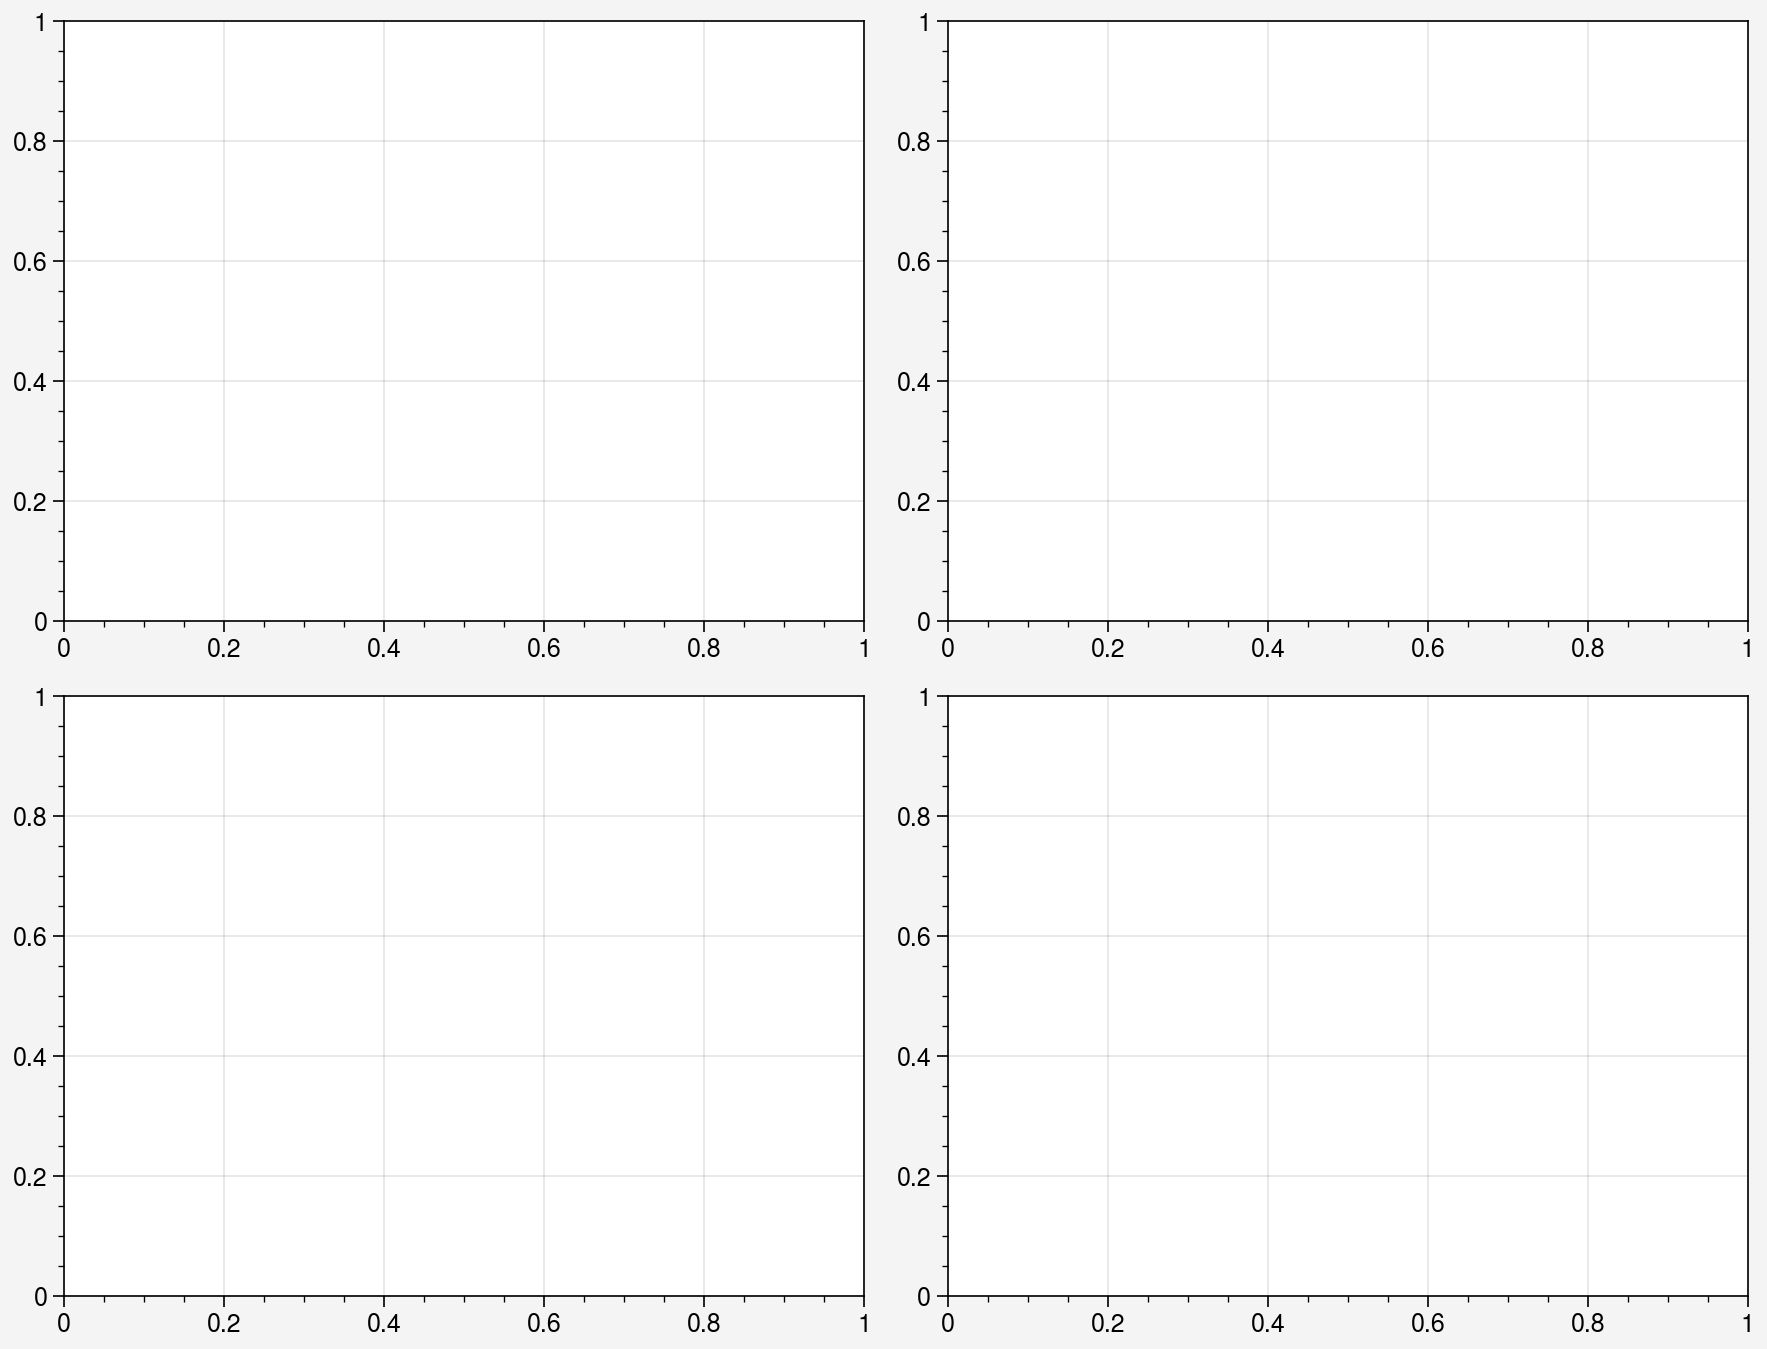

In [21]:
ytrue = np.array(allmodels[0]['ypred'])
ytrueclean = ytrue[~np.isnan(ytrue)]

# Create the distribution plot
fig, axs = pplt.subplots(nrows=2, ncols=2, refwidth=4, refheight=3, share=False)

# 1. Histogram on linear scale
ax1 = axs[0, 0]
ax1.hist(ytrue_clean, bins=50, alpha=0.7, color='blue6', density=True)
ax1.format(
    title='Precipitation Distribution (Linear)',
    xlabel='Precipitation (mm/day)',
    ylabel='Density'
)

# 2. Histogram on log scale
ax2 = axs[0, 1]
# Only plot non-zero values for log scale
ytrue_nonzero = ytrue_clean[ytrue_clean > 0]
ax2.hist(ytrue_nonzero, bins=np.logspace(np.log10(ytrue_nonzero.min()), 
                                        np.log10(ytrue_nonzero.max()), 50), 
         alpha=0.7, color='green6', density=True)
ax2.format(
    title='Precipitation Distribution (Log)',
    xlabel='Precipitation (mm/day)',
    ylabel='Density',
    xscale='log', xformatter='log'
)

# 3. Cumulative distribution
ax3 = axs[1, 0]
sorted_precip = np.sort(ytrue_clean)
cumulative = np.arange(1, len(sorted_precip) + 1) / len(sorted_precip)
ax3.plot(sorted_precip, cumulative, color='red6', linewidth=2)
ax3.format(
    title='Cumulative Distribution',
    xlabel='Precipitation (mm/day)',
    ylabel='Cumulative Probability'
)

# 4. Box plot and summary statistics
ax4 = axs[1, 1]
ax4.boxplot([ytrue_clean], labels=['Precipitation'])
ax4.format(
    title='Box Plot',
    ylabel='Precipitation (mm/day)'
)

pplt.show()

# Print summary statistics
print("=== PRECIPITATION DISTRIBUTION SUMMARY ===")
print(f"Total data points: {len(ytrue_clean):,}")
print(f"Range: {ytrue_clean.min():.3f} to {ytrue_clean.max():.3f} mm/day")
print(f"Mean: {ytrue_clean.mean():.3f} mm/day")
print(f"Median: {np.median(ytrue_clean):.3f} mm/day")
print(f"Standard deviation: {ytrue_clean.std():.3f} mm/day")

# Percentiles
percentiles = [50, 75, 90, 95, 99, 99.9]
print(f"\nPercentiles:")
for p in percentiles:
    value = np.percentile(ytrue_clean, p)
    print(f"  {p:4.1f}%: {value:8.3f} mm/day")

# Zero precipitation analysis
zero_count = np.sum(ytrue_clean == 0)
zero_percent = zero_count / len(ytrue_clean) * 100
print(f"\nZero precipitation:")
print(f"  Count: {zero_count:,} ({zero_percent:.1f}%)")

# Heavy precipitation analysis (>10 mm/day)
heavy_threshold = 10.0
heavy_count = np.sum(ytrue_clean > heavy_threshold)
heavy_percent = heavy_count / len(ytrue_clean) * 100
print(f"\nHeavy precipitation (>{heavy_threshold} mm/day):")
print(f"  Count: {heavy_count:,} ({heavy_percent:.2f}%)")
if heavy_count > 0:
    print(f"  Mean of heavy events: {ytrue_clean[ytrue_clean > heavy_threshold].mean():.3f} mm/day")

## Calculate Metrics

In [16]:
def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))

def calculate_metrics(allmodels):
    metricsdata = []
    for model in allmodels:
        ytrue = model['ytrue']
        ypred = model['ypred']
        r2   = r2_score(ytrue,ypred)
        mae  = mean_absolute_error(ytrue,ypred)
        mse  = mean_squared_error(ytrue,ypred)
        bias = np.mean(ypred-ytrue) 
        prthresh   = 0.25
        trueevents = ytrue>prthresh
        predevents = ypred>prthresh
        hitrate    = np.sum(trueevents&predevents)/np.sum(trueevents) if np.sum(trueevents)>0 else 0
        far        = np.sum(predevents&~trueevents)/np.sum(predevents) if np.sum(predevents)>0 else 0
        histtrue,_ = np.histogram(ytrue,bins=np.logspace(np.log10(globalmin),np.log10(globalmax),50),density=True)
        histpred,_ = np.histogram(ypred,bins=np.logspace(np.log10(globalmin),np.log10(globalmax),50),density=True)
        hellinger  = hellinger_distance(histtrue,histpred)
        metricsdata.append({
            'model':model['name'],
            'description':model['description'],
            'type':model['type'],
            'r2':r2,
            'mae':mae,
            'mse':mse,
            'bias':bias,
            'hitrate':hitrate,
            'far':far,
            'hellinger':hellinger})
    return pd.DataFrame(metricsdata)

metricsdf = calculate_metrics(allmodels)

## Plot Metrics

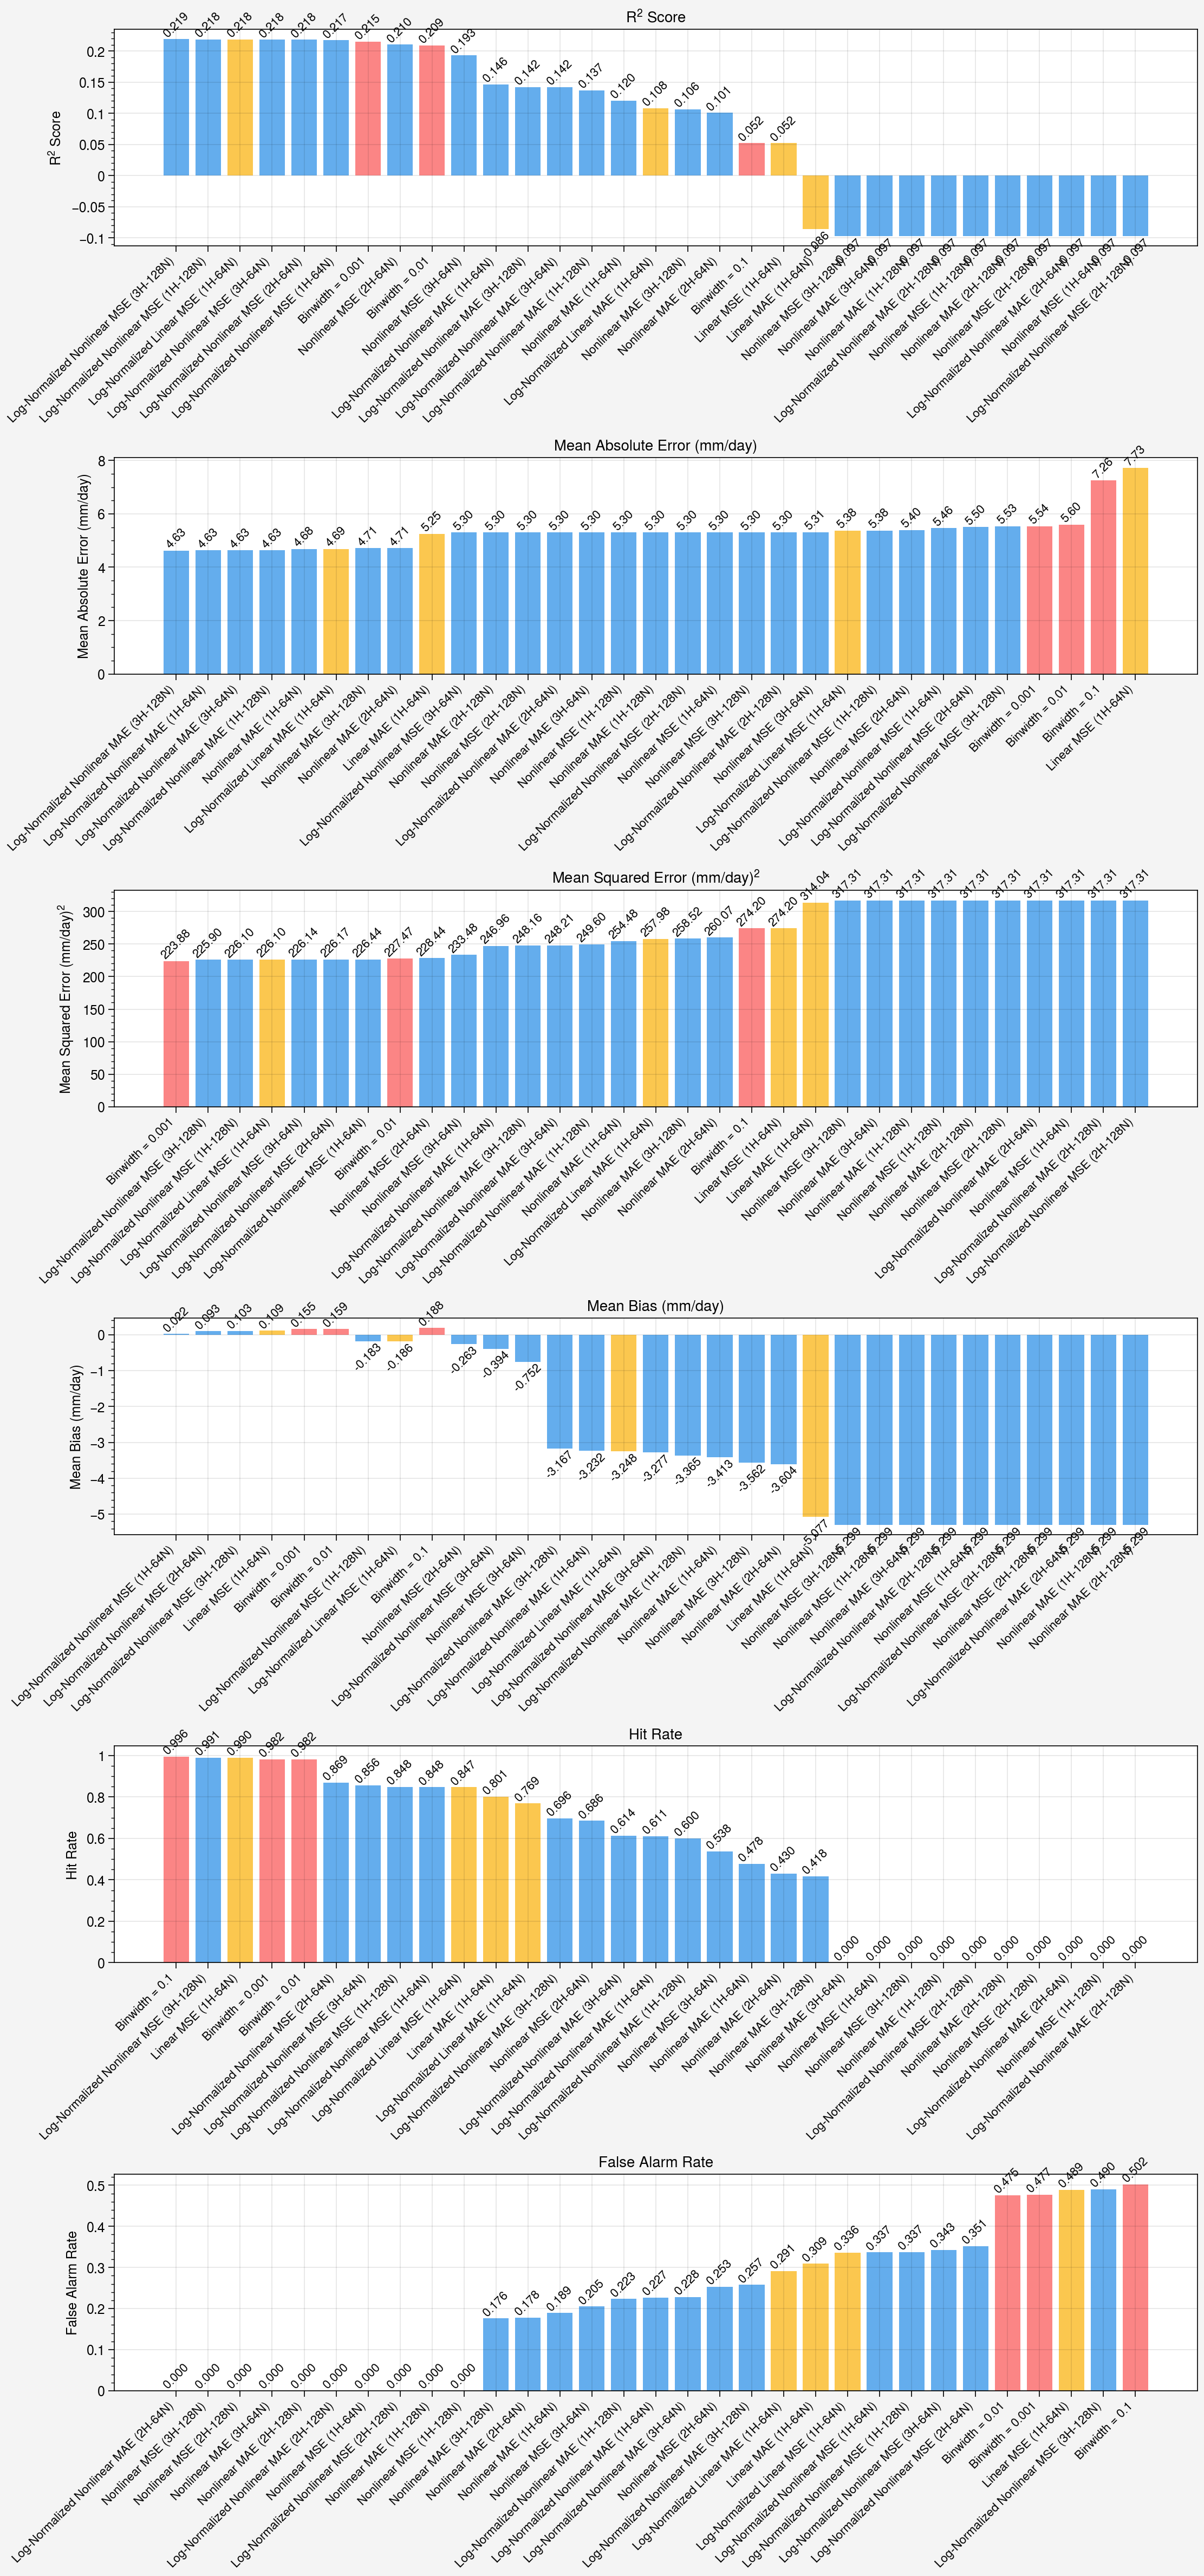

In [19]:
metricsconfig = {
    'r2': {'title':'R$^2$ Score','higher_better':True,'format':'.3f'},
    'mae':{'title':'Mean Absolute Error (mm/day)','higher_better':False,'format':'.2f'},
    'mse':{'title':'Mean Squared Error (mm/day)$^2$','higher_better':False,'format':'.2f'},
    'bias':{'title':'Mean Bias (mm/day)','higher_better':None,'format':'.3f'},
    'hitrate':{'title':'Hit Rate','higher_better':True,'format':'.3f'},
    'far':{'title':'False Alarm Rate','higher_better':False,'format':'.3f'},
    # 'hellinger':{'title':'Hellinger Distance','higher_better': False,'format':'.3f'}
}
typecolors = {
    'baseline':'red6',
    'linear':'yellow6',
    'nonlinear':'blue6'}
ncols   = 1
nrows   = (len(metricsconfig)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=10,refheight=2,share=False)
for i, (metric,config) in enumerate(metricsconfig.items()):
    row = i//ncols
    col = i%ncols
    if config['higher_better'] is True:
        sorteddf = metricsdf.sort_values(metric,ascending=False)
    elif config['higher_better'] is False:
        sorteddf = metricsdf.sort_values(metric,ascending=True)
    else:
        sorteddf = metricsdf.sort_values(metric,key=abs,ascending=True)
    colors = [typecolors[modeltype] for modeltype in sorteddf['type']]
    bars   = axs[row,col].bar(range(len(sorteddf)),sorteddf[metric],color=colors,alpha=0.7)
    axs[row,col].format(title=config['title'],ylabel=config['title'],xminorticks='none')
    for j,(bar,value) in enumerate(zip(bars,sorteddf[metric])):
        height = bar.get_height()
        va   = 'bottom' if height>=0 else 'top'
        ypos = height if height>=0 else height
        axs[row,col].text(bar.get_x()+bar.get_width()/2.,ypos,f'{value:{config["format"]}}',ha='center',va=va,fontsize=8,rotation=45)
    axs[row,col].set_xticks(range(len(sorteddf)))
    axs[row,col].set_xticklabels([desc for desc in sorteddf['description']],ha='right',fontsize=8,rotation=45)
for i in range(len(metricsconfig),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
pplt.show()

## Pareto

KeyError: 'nparams'

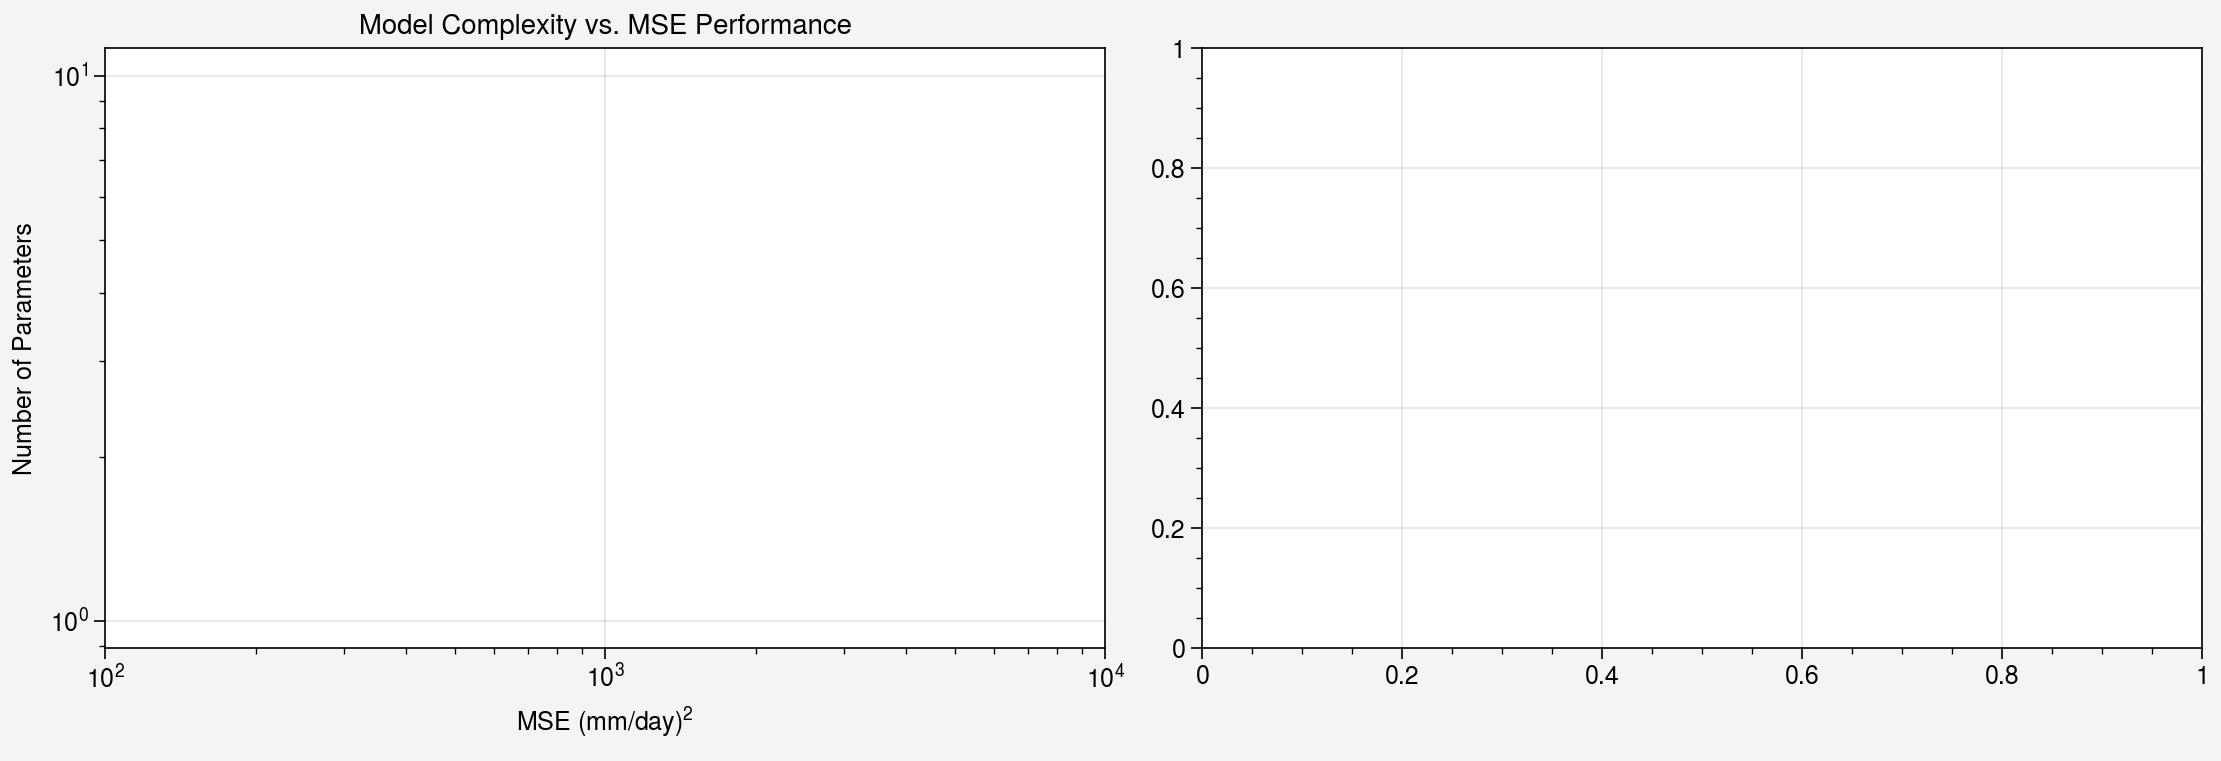

In [20]:
# Make sure we have the MSE column (calculate from RMSE if needed)
if 'mse' not in metricsdf.columns and 'rmse' in metricsdf.columns:
    metricsdf['mse'] = metricsdf['rmse'] ** 2

# Create the two-subplot figure
fig, axs = pplt.subplots(nrows=1, ncols=2, refwidth=5, refheight=3, share=False)

# Define colors and markers for model types
typecolors = {'baseline': 'red6', 'linear': 'yellow6', 'nonlinear': 'blue6'}
typemarkers = {'baseline': 'o', 'linear': 's', 'nonlinear': '^'}

# Calculate true variance for R² reference lines (estimate from best R²)
best_r2 = metricsdf['r2'].max()
worst_mse = metricsdf['mse'].max()
# Estimate true variance: MSE = var * (1 - R²), so var = MSE / (1 - R²)
truevar = worst_mse / (1 - best_r2) if best_r2 < 0.99 else metricsdf['mse'].max() * 2

r209 = truevar * (1 - 0.9)   # MSE corresponding to R² = 0.9
r2095 = truevar * (1 - 0.95) # MSE corresponding to R² = 0.95

# Plot 1: MSE vs nparams
ax1 = axs[0]
ax1.format(
    title='Model Complexity vs. MSE Performance',
    xlabel='MSE (mm/day)$^2$', xscale='log', xformatter='log',xlim=(1e2,1e4),
    ylabel='Number of Parameters', yscale='log', yformatter='log'
)

for model_type in typecolors.keys():
    subset = metricsdf[metricsdf['type'] == model_type]
    if len(subset) > 0:
        ax1.scatter(subset['mse'], subset['nparams'],
                   color=typecolors[model_type], 
                   marker=typemarkers[model_type],
                   markersize=50,
                   label=f"{model_type.capitalize()} Models",
                   alpha=0.8)

# Add R² reference lines for MSE plot (only if they're in reasonable range)
mse_range = [metricsdf['mse'].min(), metricsdf['mse'].max()]
if mse_range[0] <= r209 <= mse_range[1]:
    ax1.axvline(x=r209, color='gray', linewidth=1, linestyle='--')
    ax1.text(r209*1.1, ax1.get_ylim()[1]*0.8, 'R$^2$ = 0.9', 
             color='gray', va='top', ha='left', fontsize=8, rotation=90)

if mse_range[0] <= r2095 <= mse_range[1]:
    ax1.axvline(x=r2095, color='gray', linewidth=1, linestyle='--')
    ax1.text(r2095*1.1, ax1.get_ylim()[1]*0.8, 'R$^2$ = 0.95', 
             color='gray', va='top', ha='left', fontsize=8, rotation=90)

ax1.legend(loc='upper right', ncols=1)

# Plot 2: MAE vs nparams  
ax2 = axs[1]
ax2.format(
    title='Model Complexity vs. MAE Performance',
    xlabel='MAE (mm/day)', xscale='log', xformatter='log',xlim=(1e0,1e2),
    ylabel='Number of Parameters', yscale='log', yformatter='log'
)

for model_type in typecolors.keys():
    subset = metricsdf[metricsdf['type'] == model_type]
    if len(subset) > 0:
        ax2.scatter(subset['mae'], subset['nparams'],
                   color=typecolors[model_type],
                   marker=typemarkers[model_type], 
                   markersize=50,
                   label=f"{model_type.capitalize()} Models",
                   alpha=0.8)

ax2.legend(loc='upper right', ncols=1)

pplt.show()

# Print Pareto analysis
print("=== PARETO ANALYSIS ===")
print(f"Parameter count ranges:")
for model_type in ['baseline', 'linear', 'nonlinear']:
    subset = metricsdf[metricsdf['type'] == model_type]
    if len(subset) > 0:
        print(f"  {model_type.capitalize()}: {subset['nparams'].min():,} - {subset['nparams'].max():,} parameters")

print(f"\nPerformance ranges:")
print(f"  MSE: {metricsdf['mse'].min():.2f} - {metricsdf['mse'].max():.2f}")
print(f"  MAE: {metricsdf['mae'].min():.2f} - {metricsdf['mae'].max():.2f}")
print(f"  R²: {metricsdf['r2'].min():.3f} - {metricsdf['r2'].max():.3f}")

# Find best models in each category
print(f"\nBest performing models:")
best_mse = metricsdf.loc[metricsdf['mse'].idxmin()]
best_mae = metricsdf.loc[metricsdf['mae'].idxmin()]
best_r2 = metricsdf.loc[metricsdf['r2'].idxmax()]

print(f"  Lowest MSE: {best_mse['description']} ({best_mse['nparams']:,} params, MSE={best_mse['mse']:.2f})")
print(f"  Lowest MAE: {best_mae['description']} ({best_mae['nparams']:,} params, MAE={best_mae['mae']:.2f})")
print(f"  Highest R²: {best_r2['description']} ({best_r2['nparams']:,} params, R²={best_r2['r2']:.3f})")